In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import pandas as pd
import numpy as np
from datetime import datetime
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
from bokeh.models.tools import HoverTool
from bokeh.io.export import get_screenshot_as_png
from bokeh.io import output_notebook
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend
from keras import layers
from keras.models import Sequential, Model
from keras.preprocessing.sequence import TimeseriesGenerator

from keras.layers import CuDNNLSTM


import utils

C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using plaidml.keras.backend backend.


In [2]:
# check if we have a gpu recognized by tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
val_split = 0.2

train, test = utils.load_data(random=False)

vidx = int(len(train) * (1 - val_split))
train, validate = train[vidx:], train[:vidx]
train.head()

,target,t_max,t_avg,t_min,dwpt_max,dwpt_avg,dwpt_min,rh_max,rh_avg,rh_min,...,ws_min,pr_max,pr_avg,pr_min,prcp_total,day_of_year,weekday,week,month,year
2017-07-12,8583.962414,90,84.4,79,74,70.9,68,81,64.8,48,...,0,30.0,29.9,29.9,0.00,193,2,28,7,2017
2017-07-13,8923.734812,93,83.8,74,73,71.6,70,97,68.2,48,...,3,30.0,29.9,29.9,0.00,194,3,28,7,2017
2017-07-14,7047.382986,73,68.4,65,70,66.9,64,100,94.8,87,...,3,30.1,30.0,29.9,0.01,195,4,28,7,2017
2017-07-15,6519.485417,85,73.7,66,70,66.3,62,100,80.8,49,...,0,29.9,29.9,29.9,0.47,196,5,28,7,2017
2017-07-16,6664.957241,85,78.2,71,67,64.3,61,78,63.0,44,...,0,30.0,29.9,29.9,0.00,197,6,28,7,2017


In [4]:
train_labels = np.array(train['target']).reshape(-1, 1)
train.drop(columns=['target'], inplace=True)

validate_labels = np.array(validate['target']).reshape(-1, 1)
validate.drop(columns=['target'], inplace=True)

test_labels = np.array(test['target']).reshape(-1, 1)
test.drop(columns=['target'], inplace=True)

train.head()

,t_max,t_avg,t_min,dwpt_max,dwpt_avg,dwpt_min,rh_max,rh_avg,rh_min,ws_max,...,ws_min,pr_max,pr_avg,pr_min,prcp_total,day_of_year,weekday,week,month,year
2017-07-12,90,84.4,79,74,70.9,68,81,64.8,48,21,...,0,30.0,29.9,29.9,0.00,193,2,28,7,2017
2017-07-13,93,83.8,74,73,71.6,70,97,68.2,48,16,...,3,30.0,29.9,29.9,0.00,194,3,28,7,2017
2017-07-14,73,68.4,65,70,66.9,64,100,94.8,87,15,...,3,30.1,30.0,29.9,0.01,195,4,28,7,2017
2017-07-15,85,73.7,66,70,66.3,62,100,80.8,49,13,...,0,29.9,29.9,29.9,0.47,196,5,28,7,2017
2017-07-16,85,78.2,71,67,64.3,61,78,63.0,44,15,...,0,30.0,29.9,29.9,0.00,197,6,28,7,2017


In [5]:
scaler = StandardScaler()
train = scaler.fit_transform(train)
validate = scaler.transform(validate)
test = scaler.transform(test)

label_scaler = StandardScaler()
train_labels = label_scaler.fit_transform(train_labels)
validate_labels = label_scaler.transform(validate_labels)
test_labels = label_scaler.transform(test_labels)

In [6]:
timesteps = 7  # naively try using the week before
days_ahead = 1
epochs = 10

train_gen = TimeseriesGenerator(train, train_labels, length=timesteps,
                                sampling_rate=1, batch_size=days_ahead)
validate_gen = TimeseriesGenerator(validate, validate_labels, length=timesteps,
                              sampling_rate=1, batch_size=days_ahead)

x, y = validate_gen[0]
y

array([[-0.12461136]])

In [7]:
model = Sequential()

input_shape = (timesteps, train.shape[1])

model.add(layers.LSTM(128, input_shape=input_shape))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, name='output'))

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

INFO:plaidml:Opening device "opencl_nvidia_geforce_rtx_2070_super.0"


In [8]:
history = model.fit_generator(
    train_gen,
    epochs=epochs,
    workers=8,
    validation_data=validate_gen
)

Epoch 1/10
986/986 [==============================] - 54s 55ms/step - loss: 0.3894 - mean_absolute_error: 0.4572 - val_loss: 0.5291 - val_mean_absolute_error: 0.5401
Epoch 2/10
986/986 [==============================] - 48s 49ms/step - loss: 0.2194 - mean_absolute_error: 0.3463 - val_loss: 0.9474 - val_mean_absolute_error: 0.7726
Epoch 3/10
986/986 [==============================] - 54s 55ms/step - loss: 0.1704 - mean_absolute_error: 0.3019 - val_loss: 0.9256 - val_mean_absolute_error: 0.6838: 2s - lo
Epoch 4/10
986/986 [==============================] - 56s 56ms/step - loss: 0.1443 - mean_absolute_error: 0.2776 - val_loss: 1.0581 - val_mean_absolute_error: 0.7863
Epoch 5/10
986/986 [==============================] - 56s 57ms/step - loss: 0.1219 - mean_absolute_error: 0.2521 - val_loss: 1.2293 - val_mean_absolute_error: 0.8671
Epoch 6/10
986/986 [==============================] - 58s 59ms/step - loss: 0.1270 - mean_absolute_error: 0.2529 - val_loss: 1.3271 - val_mean_absolute_error: 0.

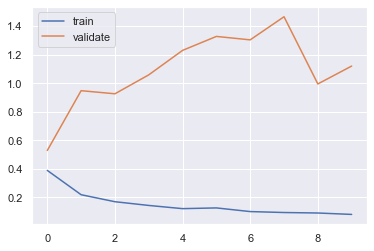

In [9]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validate')
plt.legend()
plt.show()

Oof, heavy overfitting. LSTM may not be the best choice given our choice of time-series periodicity (1 day per row). This current model takes the previous weeks weather into account, which seems to not work well.

I imagine this type of model would work well if we were using more granular data.